# Домашняя работа. Деревья решений.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](99-extra__ml-course-msu-Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'./data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import load_digits
from google.colab import files
uploaded = files.upload()

Saving winequality-red.csv.gz to winequality-red.csv (1).gz


In [14]:
df = pd.read_csv('winequality-red.csv.gz', compression='gzip', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [15]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

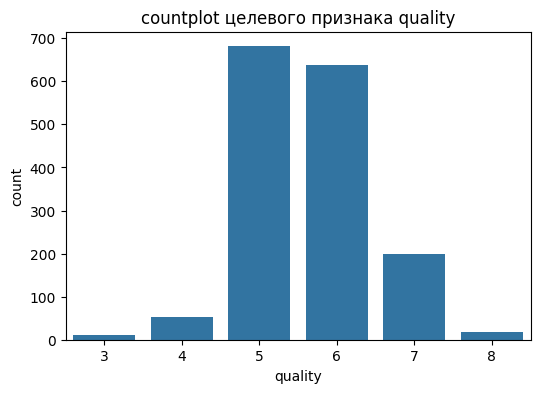

Количество представителей каждого класса: quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df)
plt.title("countplot целевого признака quality")
plt.show()
print("Количество представителей каждого класса:",df['quality'].value_counts())
x = df.drop(columns=['quality'])
y = df['quality']

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов.

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [17]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

cv = KFold(n_splits=5, random_state=42, shuffle=True)
knn = KNeighborsClassifier(n_neighbors=10)
scores_knn = cross_val_score(knn, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для KNeighborsClassifier с 10 соседями: {:.6f}, Std: {:.6f}".format(scores_knn.mean(), scores_knn.std()))


Среднее значение accuracy для KNeighborsClassifier с 10 соседями: 0.512220, Std: 0.026461


In [18]:
pipeline_knn_scaled = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))
scores_knn_scaled = cross_val_score(pipeline_knn_scaled, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для KNeighborsClassifier с 10 соседями и масштабированием: {:.6f}, Std: {:.6f}".format(scores_knn_scaled.mean(), scores_knn_scaled.std()))

Среднее значение accuracy для KNeighborsClassifier с 10 соседями и масштабированием: 0.581634, Std: 0.019192


In [20]:
ridge = RidgeClassifier(random_state=42)
scores_ridge = cross_val_score(ridge, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для RidgeClassifier: {:.6f}, Std: {:.6f}".format(scores_ridge.mean(), scores_ridge.std()))

Среднее значение accuracy для RidgeClassifier: 0.583538, Std: 0.039966


In [19]:
decision_tree = DecisionTreeClassifier(random_state=42)
scores_decision_tree = cross_val_score(decision_tree, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для DecisionTreeClassifier: {:.6f}, Std: {:.6f}".format(scores_decision_tree.mean(), scores_decision_tree.std()))


Среднее значение accuracy для DecisionTreeClassifier: 0.617896, Std: 0.033631


In [20]:
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42)
scores_bagging = cross_val_score(bagging, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для BaggingClassifier с 100 деревьями: {:.6f}, Std: {:.6f}".format(scores_bagging.mean(), scores_bagging.std()))

Среднее значение accuracy для BaggingClassifier с 100 деревьями: 0.697966, Std: 0.035447


In [21]:
bagging_half_features = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=0.5, random_state=42)
scores_bagging_half_features = cross_val_score(bagging_half_features, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для BaggingClassifier с 100 деревьями и половиной признаков: {:.6f}, Std: {:.6f}".format(scores_bagging_half_features.mean(), scores_bagging_half_features.std()))

Среднее значение accuracy для BaggingClassifier с 100 деревьями и половиной признаков: 0.694835, Std: 0.022539


In [22]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
scores_random_forest = cross_val_score(random_forest, x, y, cv=cv, scoring='accuracy')
print("Среднее значение accuracy для RandomForestClassifier с 100 деревьями: {:.6f}, Std: {:.6f}".format(scores_random_forest.mean(), scores_random_forest.std()))

Среднее значение accuracy для RandomForestClassifier с 100 деревьями: 0.701714, Std: 0.028722


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без

в методе ближайших соседей расстояния между объектами искажаются из-за доминирования больших признаков. условно говоря, признак с БОЛЬШИМ диапазоном значений например до 100000 вносит больший вклад в расстояние, чем признак с МАЛЕНЬКИМ значением до 100. с масштабированием вклад признаков в расстояние будет учитываться равномерно.

- почему масштабирование не важно для деревьев решений

масштабирование не влияет на производительность деревьев решений, потому что они работают с относительными, а не абсолютными значениями признаков. деревья решений не вычисляют расстояния между объектами. они просто определяют, на какой стороне порога находится объект.

- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)

разница в качестве модели 100% признаков незначительная, хотя использование всех признаков может обеспечивать большую точность. модель с 50% признаков хотя и менее точная, но у неё лучше обобщающая способность модели за счёт снижения переобучения что дает более стабильные предсказания

- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

наибольшее отклонение от среднего качества предсказаний у RidgeClassifier. потому что это линейная модель и если данные сильно различаются, то и стабильность предсказаний будет хуже. в сложных моделях это компенсируется ансаблированием.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

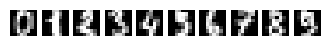

In [23]:
plt.figure(figsize=(4, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(load_digits().images[i], cmap='gray')
    plt.axis('off')
plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [25]:
decision_tree = DecisionTreeClassifier(random_state=42)
scores_decision_tree = cross_val_score(decision_tree, x, y, cv=10, scoring='accuracy')
print("Среднее значение accuracy для DecisionTreeClassifier:", scores_decision_tree.mean())

Среднее значение accuracy для DecisionTreeClassifier: 0.4777830188679245


In [27]:
bagging = BaggingClassifier(n_estimators=100, random_state=42)
scores_bagging = cross_val_score(bagging, x, y, cv=10, scoring='accuracy')
print("Среднее значение accuracy для BaggingClassifier с 100 деревьями:", scores_bagging.mean())

Среднее значение accuracy для BaggingClassifier с 100 деревьями: 0.5578301886792453


In [29]:
num_features = x.shape[1]
bagging_max_features = BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(num_features)), random_state=42)
scores_bagging_max_features = cross_val_score(bagging_max_features, x, y, cv=10, scoring='accuracy')
print("Среднее значение accuracy для BaggingClassifier с 100 деревьями и ограничением на max_features:", scores_bagging_max_features.mean())


Среднее значение accuracy для BaggingClassifier с 100 деревьями и ограничением на max_features: 0.5603380503144655


In [31]:
bagging_split_features = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_features=int(np.sqrt(num_features)), random_state=42),
    n_estimators=100,
    random_state=42
)
scores_bagging_split_features = cross_val_score(bagging_split_features, x, y, cv=10, scoring='accuracy')
print("Среднее значение accuracy для BaggingClassifier с 100 деревьями и ограничением max_features в разбиениях деревьев:", scores_bagging_split_features.mean())

Среднее значение accuracy для BaggingClassifier с 100 деревьями и ограничением max_features в разбиениях деревьев: 0.5697366352201257


In [33]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
scores_random_forest = cross_val_score(random_forest, x, y, cv=10, scoring='accuracy')
print("Среднее значение accuracy для RandomForestClassifier с 100 деревьями:", scores_random_forest.mean())

Среднее значение accuracy для RandomForestClassifier с 100 деревьями: 0.5734905660377358


### 2.3 В чём разница? (3 балла)

Ответье на вопрос:

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

Ограничение признаков на уровне разбиений (в каждом узле) повышает случайность и разнообразие внутри каждого дерева, что улучшает стабильность предсказаний ансамбля. Ограничение признаков для каждого дерева, напротив, ограничивает информацию, доступную дереву, что снижает качество предсказаний, так как деревья становятся менее информативными.

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [37]:
n_estimators_options = [1, 5, 10, 15, 50, 100, 150, 200, 300]
mean_accuracies = []
for n in n_estimators_options:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, x, y, cv=10, scoring='accuracy')
    mean_accuracies.append(scores.mean())


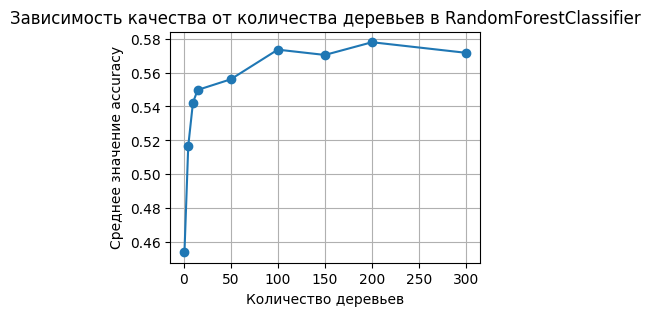

In [41]:
plt.figure(figsize=(4, 3))
plt.plot(n_estimators_options, mean_accuracies, marker='o')
plt.xlabel("Количество деревьев")
plt.ylabel("Среднее значение accuracy")
plt.title("Зависимость качества от количества деревьев в RandomForestClassifier")
plt.grid(True)
plt.show()

In [39]:
best_n_estimators = n_estimators_options[np.argmax(mean_accuracies)]
best_accuracy = max(mean_accuracies)
print(f"Оптимальное количество деревьев: {best_n_estimators}, при котором accuracy = {best_accuracy}")

Оптимальное количество деревьев: 200, при котором accuracy = 0.5778694968553459


### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [47]:
max_features_options = list(range(1, 65, 5))
mean_accuracies = []

for max_features in max_features_options:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(rf, x, y, cv=10, scoring='accuracy')
    mean_accuracies.append(scores.mean())

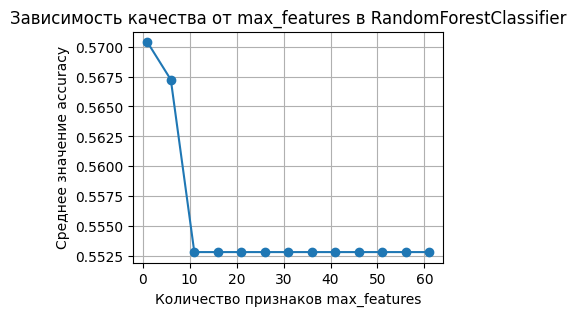

In [52]:
plt.figure(figsize=(4, 3))
plt.plot(max_features_options, mean_accuracies, marker='o')
plt.xlabel("Количество признаков max_features")
plt.ylabel("Среднее значение accuracy")
plt.title("Зависимость качества от max_features в RandomForestClassifier")
plt.grid(True)
plt.show()

In [53]:
best_max_features = max_features_options[np.argmax(mean_accuracies)]
best_accuracy = max(mean_accuracies)
print(f"Оптимальное количество признаков: {best_max_features}, при котором accuracy = {best_accuracy}")

Оптимальное количество признаков: 1, при котором accuracy = 0.570377358490566


### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?

При увеличении числа деревьев качество предсказания случайного леса стабилизируется и начинает выходить на плато, то есть дополнительное увеличение деревьев практически не улучшает результат. Использование слишком большого количества деревьев значительно увеличивает вычислительные затраты без существенного прироста точности, поэтому лучше подобрать оптимальное количество деревьев.
- Как зависит качество предсказания в дереве в зависимости от max_features?

Значение max_features контролирует, сколько признаков доступно каждому дереву для выбора на каждом разбиении. При слишком низких значениях могут быть пропущены важные признаки, что снижает точность, а слишком высокие значения приводят к снижению разнообразия деревьев, что также может ухудшить качество.
- Почему качество зависит от max_features?

Значение max_features влияет на качество предсказания, поскольку оно контролирует степень разнообразия деревьев в лесу. При меньшем max_features деревья строят разбиения более случайным образом, что увеличивает их различия и снижает вероятность переобучения, повышая качество предсказания на новых данных. Напротив, слишком большое значение max_features делает деревья более похожими друг на друга, уменьшая случайность и увеличивая риск переобучения, что ухудшает обобщающую способность модели и, соответственно, её качество предсказания на тестовых данных.
- Как глубина деревьев влияет на качество случайного леса?

Глубина деревьев определяет, насколько сильно каждое дерево может подстраиваться под данные. Слишком глубокие деревья могут привести к переобучению, так как они начинают запоминать данные, а не обобщать их. Ограниченная глубина деревьев уменьшает переобучение и улучшает обобщающую способность случайного леса.

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)